## RQ3 Full Process

General plan:
- Load the tokens for class 3 and 6 (created in RQ2)
- Assign each token their cluster from RQ2
- Isolate the clusters I'm interested in 
- Compare those clusters (word cloud, cluster membership metric?)

**IMPORTANT** When using only trails that intersect with Natura sites, the number of trails for class 3 is very low (67). There is a noticable difference between words in the clusters, but because there is so little data for class 3, the results aren't very meaningful. I therefore expand the trail filter to include trails which do not intersect with Natura sites (but are still filtered according to their max class in the forest consensus map). I use the clusters from RQ2 so any new tokens not included in the Natura-only clustering are not represented here - in this way I'm still looking at the clusters/tokens that are relevant to Natura but applying them to trails outside Natura as well.

In [1]:
# SETUP

# Import packages
import pandas as pd
import pickle

import spacy
from deep_translator import GoogleTranslator
from collections import Counter

import matplotlib.pyplot as plt
from wordcloud import WordCloud


### Step 1: Load tokens for class 3 and 6

These were created as part of RQ2. They are separated by class and also by Natura/Non-Natura

In [3]:
# STEP 1: LOAD & COMBINE CLASS TOKENS

# Load class 3 and 6 Natura tokens
filtered_tokens_nat_c3 = pickle.load(open("./processing/final_tokens_nat_c3.p", "rb"))
filtered_tokens_nat_c6 = pickle.load(open("./processing/final_tokens_nat_c6.p", "rb"))

# Load class 3 and 6 Non-Natura tokens
filtered_tokens_nonnat_c3 = pickle.load(open("./processing/final_tokens_nonnat_c3.p", "rb"))
filtered_tokens_nonnat_c6 = pickle.load(open("./processing/final_tokens_nonnat_c6.p", "rb"))

# Combine Natura and Non-Natura tokens
filtered_tokens_all_c3 = filtered_tokens_nat_c3 + filtered_tokens_nonnat_c3
filtered_tokens_all_c6 = filtered_tokens_nat_c6 + filtered_tokens_nonnat_c6


In [4]:
# STEP 1: CHECK GENERAL RESULTS

word_freq_c3 = Counter(filtered_tokens_all_c3)
common_words_c3 = word_freq_c3.most_common(20)

word_freq_c6 = Counter(filtered_tokens_all_c6)
common_words_c6 = word_freq_c6.most_common(20)

common_words_c3[0:9], common_words_c6[0:9]

([('wanderung', 17),
  ('weg', 12),
  ('runde', 10),
  ('schöne', 9),
  ('entlang', 8),
  ('schöner', 8),
  ('m', 7),
  ('richtung', 7),
  ('route', 7)],
 [('weg', 205),
  ('blick', 143),
  ('wald', 131),
  ('parkplatz', 119),
  ('aussicht', 117),
  ('m', 117),
  ('links', 117),
  ('rechts', 115),
  ('wanderung', 95)])

### Step 2: Assign clusters

Assign each token their cluster from rq2_step2_text_analysis.ipynb

In [5]:
# STEP 2: LOAD TOKEN/CLUSTER LOOKUP FROM RQ2

token_cluster_lookup = pickle.load(open("./processing/token_cluster_all.p", "rb"))

token_cluster_lookup_dict = token_cluster_lookup.set_index("token").to_dict()["cluster"]

token_cluster_lookup_dict

{'breite': 0,
 'forstwege': 10,
 'pfade': 10,
 'halber': 9,
 'strecke': 10,
 'einkehren': 1,
 'montag': 0,
 'ruhetag': 10,
 'rinken': 5,
 'schauinsland': 5,
 'arten': 0,
 'menschen': 0,
 'geeignet': 0,
 'gipfel': 10,
 'abgerundet': 0,
 'bietet': 0,
 'guten': 3,
 'blick': 11,
 'schwarzen': 9,
 'dschungel': 8,
 'nördlichen': 0,
 'hang': 1,
 'schweizer': 9,
 'berge': 8,
 'liechtenstein': 0,
 'feldberg': 5,
 'm': 7,
 'schwarzes': 9,
 'deutschland': 0,
 'linke': 9,
 'gabelung': 1,
 'feldsee': 5,
 'see': 8,
 'bank': 9,
 'top': 6,
 'monolith': 9,
 'titisee': 5,
 'camping': 1,
 'teich': 8,
 'ruhestein': 5,
 'bartholomä': 5,
 'schönen': 3,
 'fuss': 10,
 'watzmann': 8,
 'ostwand': 9,
 'gleichem': 0,
 'weg': 2,
 'entlang': 10,
 'richtung': 2,
 'norden': 9,
 'beginnt': 0,
 'wald': 8,
 'zunehmend': 0,
 'ausgesetzter': 8,
 'wanderer': 10,
 'höhenangst': 9,
 'steig': 10,
 'erreicht': 0,
 'schließlich': 0,
 'aussichtspunkt': 10,
 'schöner': 3,
 'aussicht': 11,
 'königssee': 5,
 'minuten': 7,
 'schön':

In [6]:
# STEP 2: MAP TOKENS TO CLUSERS

# Create a df with tokens as one column
final_tokens_c3_df = pd.DataFrame({'token': filtered_tokens_all_c3})
final_tokens_c6_df = pd.DataFrame({'token': filtered_tokens_all_c6})

# Add cluster column using dictionary as lookup
final_tokens_c3_df["cluster"] = final_tokens_c3_df["token"].map(token_cluster_lookup_dict)
final_tokens_c6_df["cluster"] = final_tokens_c6_df["token"].map(token_cluster_lookup_dict)

# Remove NaN entries 
# these are ones that are not included in the RQ2 clusters (either because not in word2vec model 
# or because they are extra words from non-Natura sites that were not present in RQ2 clustering)
final_tokens_c3_df = final_tokens_c3_df.dropna()
final_tokens_c6_df = final_tokens_c6_df.dropna()

# Convert cluster number to int
final_tokens_c3_df["cluster"] = final_tokens_c3_df["cluster"].astype(int)
final_tokens_c6_df["cluster"] = final_tokens_c6_df["cluster"].astype(int)

final_tokens_c3_df

,token,cluster
0,breite,0
1,forstwege,10
2,pfade,10
3,halber,9
4,strecke,10
...,...,...
1230,steilem,10
1231,aufstieg,10
1232,panorama,10
1233,rückweg,10


### Step 3: Isolate clusters of interest

For RQ3 I will only focus on the clusters of interest for CES. For that reason I extract the following clusters:
- 3 "Aesthetic values 1 (adjectives)"
- 4 "Historical & religious values"
- 8 "Natural features"
- 11 "Aesthetic values 2 (visual perception)"

In [74]:
# STEP 3: FILTER SPECIFIC CLUSTERS

# Extract the clusters of interest
filtered_clusters_c3 = final_tokens_c3_df[(final_tokens_c3_df["cluster"]==3) | (final_tokens_c3_df["cluster"]==4) | (final_tokens_c3_df["cluster"]==8) | (final_tokens_c3_df["cluster"]==11)]
filtered_clusters_c6 = final_tokens_c6_df[(final_tokens_c6_df["cluster"]==3) | (final_tokens_c6_df["cluster"]==4) | (final_tokens_c6_df["cluster"]==8) | (final_tokens_c6_df["cluster"]==11)]

filtered_clusters_c3

,token,cluster
20,guten,3
21,blick,11
23,dschungel,8
28,berge,8
38,see,8
...,...,...
1211,winter,8
1218,schönem,3
1222,spaß,3
1227,teiche,8


### Step 4: Compare Class 3 and 6 Results

Create visualisations for comparing class 3 and 6 results.
- wordcloud
- bar chart for total tokens per cluster
- bar chart for token frequency per cluster


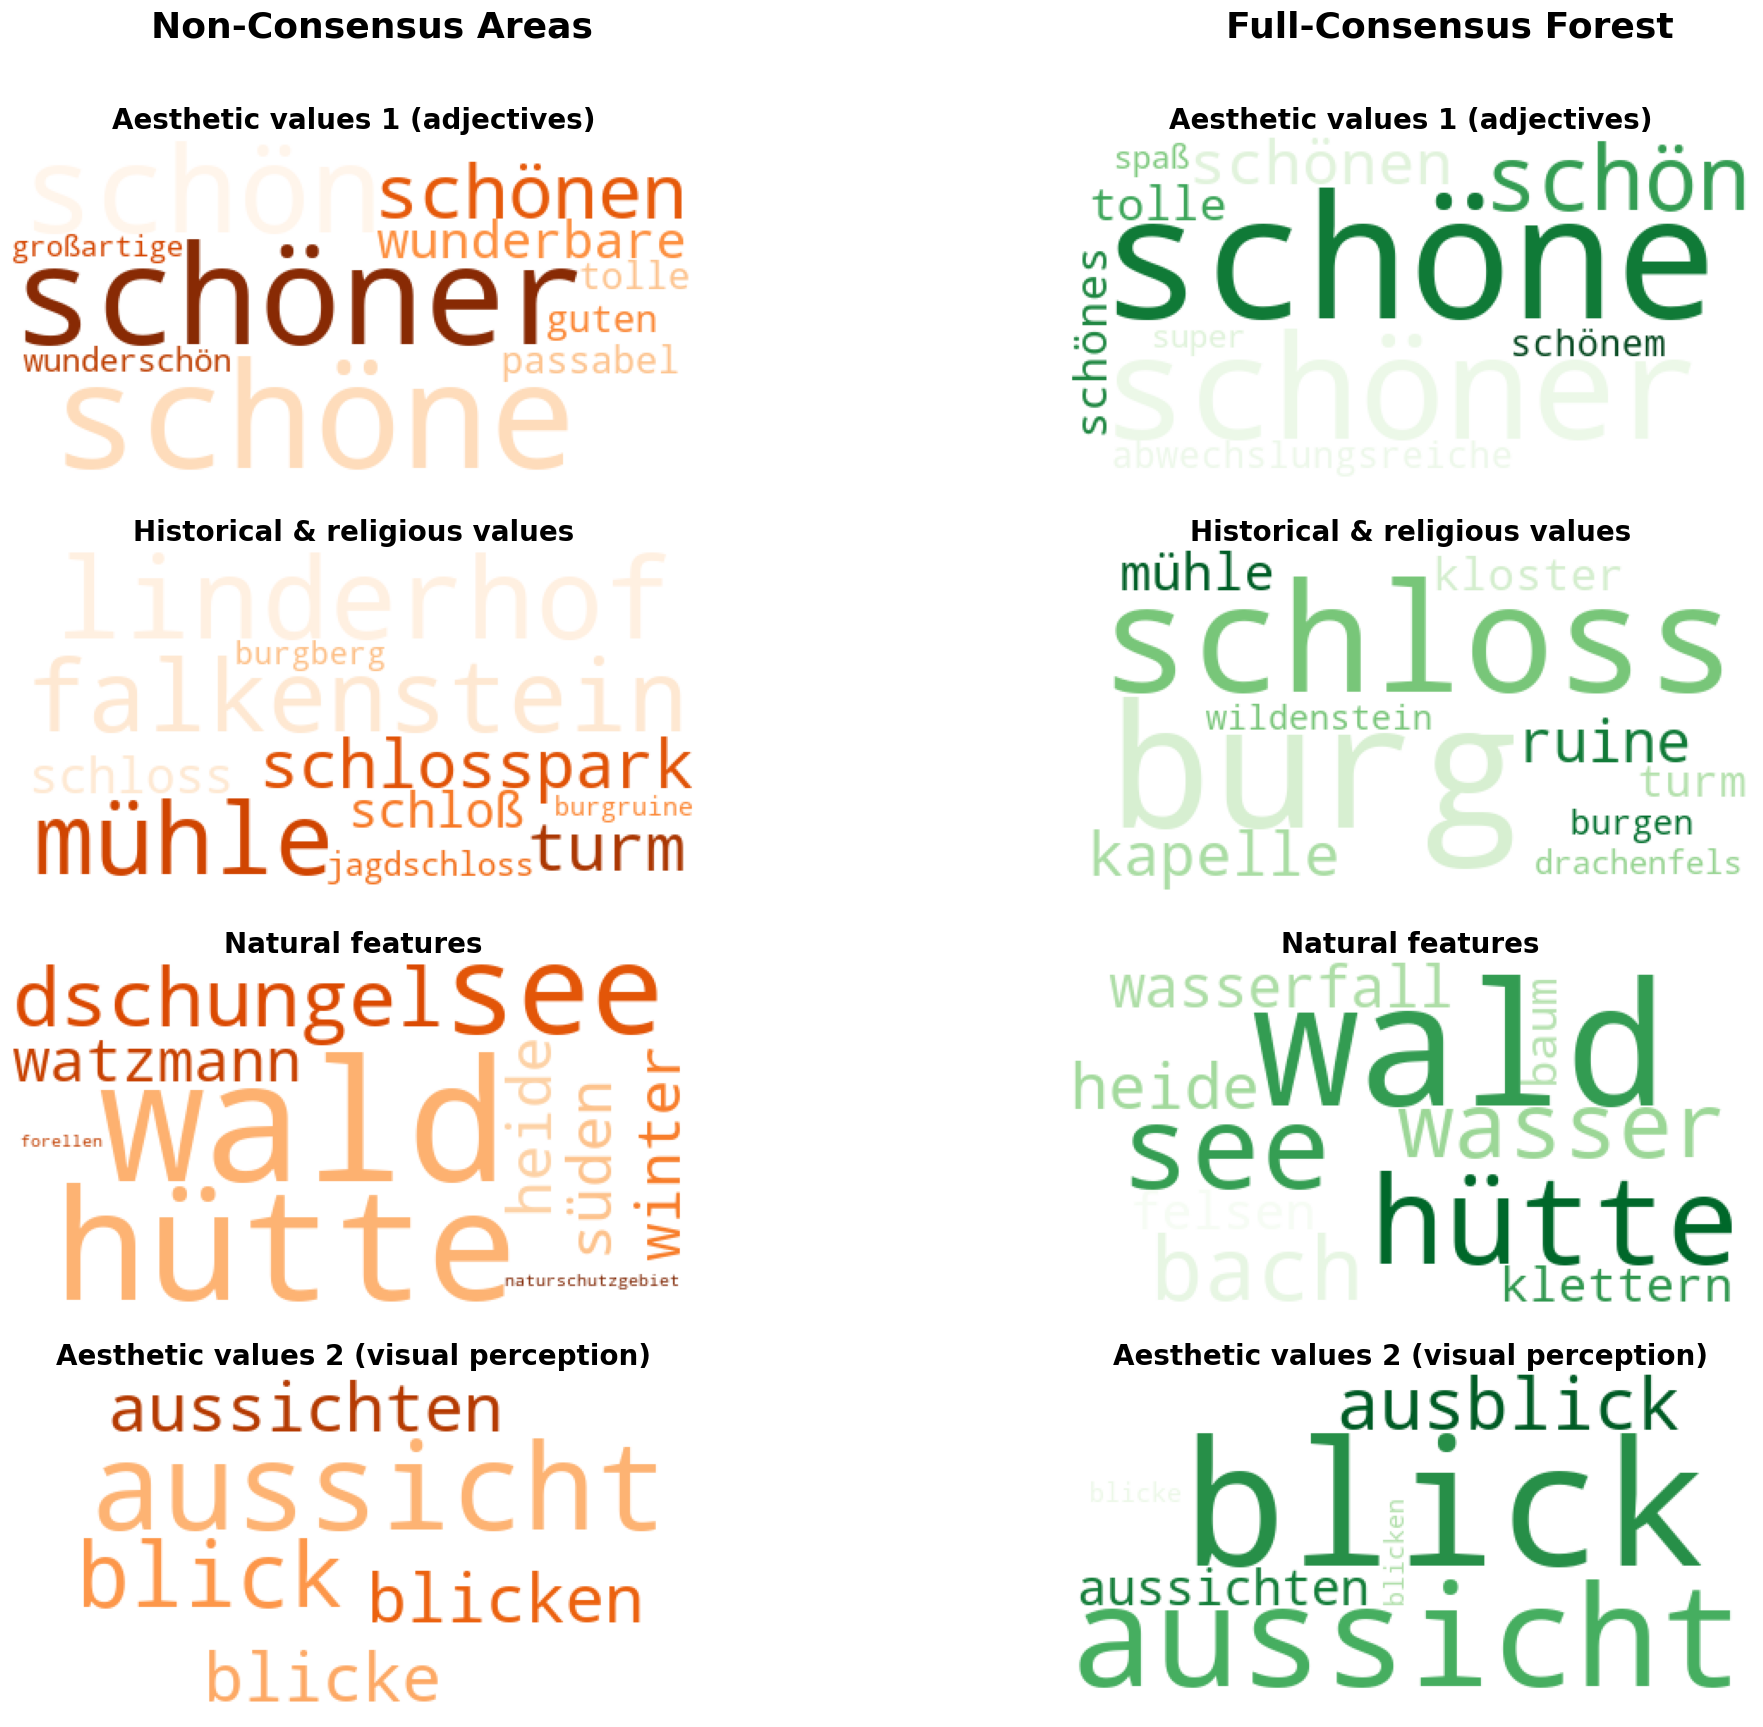

In [73]:
# STEP 3: WORD CLOUDS

# Create a function to count the token frequencies for each cluster 
def get_cluster_freq(df, clus_num):
    token_list = df.loc[df["cluster"] == clus_num, "token"]
    delimiter = " " 
    join_str = delimiter.join(token_list)
    freqs = Counter(join_str.split())
    return freqs

# Create empty lists for storing the word cloud plots 
all_wc_c3 = []
all_wc_c6 = []

# For each cluster number use the get_cluster_freq function to get token frequencies,
# input those frequencies into the WordCloud generator and append each wc to list
# IMPORTANT: I HAVE LIMITED TO SHOW TOP 10 TOKENS IN EACH CLUSTER

# Generate class 3 word clouds
for clus_num in [3, 4, 8, 11]:  
    freqs = get_cluster_freq(filtered_clusters_c3, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='Oranges', 
                   max_words=10).generate_from_frequencies(freqs)
    all_wc_c3.append(wc)

# Generate class 6 word clouds
for clus_num in [3, 4, 8, 11]:  
    freqs = get_cluster_freq(filtered_clusters_c6, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='Greens', 
                   max_words=10).generate_from_frequencies(freqs)
    all_wc_c6.append(wc)

# Create custom titles (shared for both c3 and c6)
all_titles = ["Aesthetic values 1 (adjectives)", 
              "Historical & religious values", 
              "Natural features",
              "Aesthetic values 2 (visual perception)"]

# Create a single figure with 5 rows and 2 columns
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))

# Iterate through each word cloud to plot (class 3 in 1st column, class 6 in 2nd column) 
for i in range(4):
    # Class 3 word clouds
    axes[i, 0].imshow(all_wc_c3[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title(all_titles[i], fontsize=20, fontweight="bold")

    # Class 6 word clouds
    axes[i, 1].imshow(all_wc_c6[i])
    axes[i, 1].axis('off')
    axes[i, 1].set_title(all_titles[i], fontsize=20, fontweight="bold")


# Adjust white space at the top to fit in main titles and adjust space between rows
plt.subplots_adjust(top=0.90, hspace=0.2)

# Add column titles (first two numbers control the position)
fig.text(0.22, 0.95, "Non-Consensus Areas", fontsize=26, fontweight='bold')
fig.text(0.65, 0.95, "Full-Consensus Forest", fontsize=26, fontweight='bold')

# Save the figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_word_clouds.png', bbox_inches='tight')

# Display figure
plt.show()

In [75]:
# STEP 3: CLASS COMPARISON

# Get the total counts across all clusters for each class
c3_total_token_count = len(filtered_clusters_c3)
c6_total_token_count = len(filtered_clusters_c6)

print(f"Total Tokens for Class 3: {c3_total_token_count}")
print(f"Total Tokens for Class 6: {c6_total_token_count}")

Total Tokens for Class 3: 153
Total Tokens for Class 6: 2700


In [ ]:
# STEP 3: CLUSTER COMPARISON

# Create dfs for storing total number of tokens for each cluster for each class
c3_token_counts_df = pd.DataFrame()
c6_token_counts_df = pd.DataFrame()

# Create column for cluster names 
# note that all_titles is defined in word cloud code
c3_token_counts_df["cluster_name"] = all_titles
c6_token_counts_df["cluster_name"] = all_titles

# Create empty list for storing counts per cluster for each class
c3_token_counts = []
c6_token_counts = []

# Count tokens per cluster and append to list (class 3)
for clus_num in [3, 4, 8, 11]:
    count = len(filtered_clusters_c3[filtered_clusters_c3["cluster"] == clus_num])
    c3_token_counts.append(count)

# Count tokens per cluster and append to list (class 6)
for clus_num in [3, 4, 8, 11]:
    count = len(filtered_clusters_c6[filtered_clusters_c6["cluster"] == clus_num])
    c6_token_counts.append(count)

# Combine count lists and add to dfs
c3_token_counts_df["token_count"] = c3_token_counts 
c6_token_counts_df["token_count"] = c6_token_counts 

# Check
#c3_token_counts_df, c6_token_counts_df


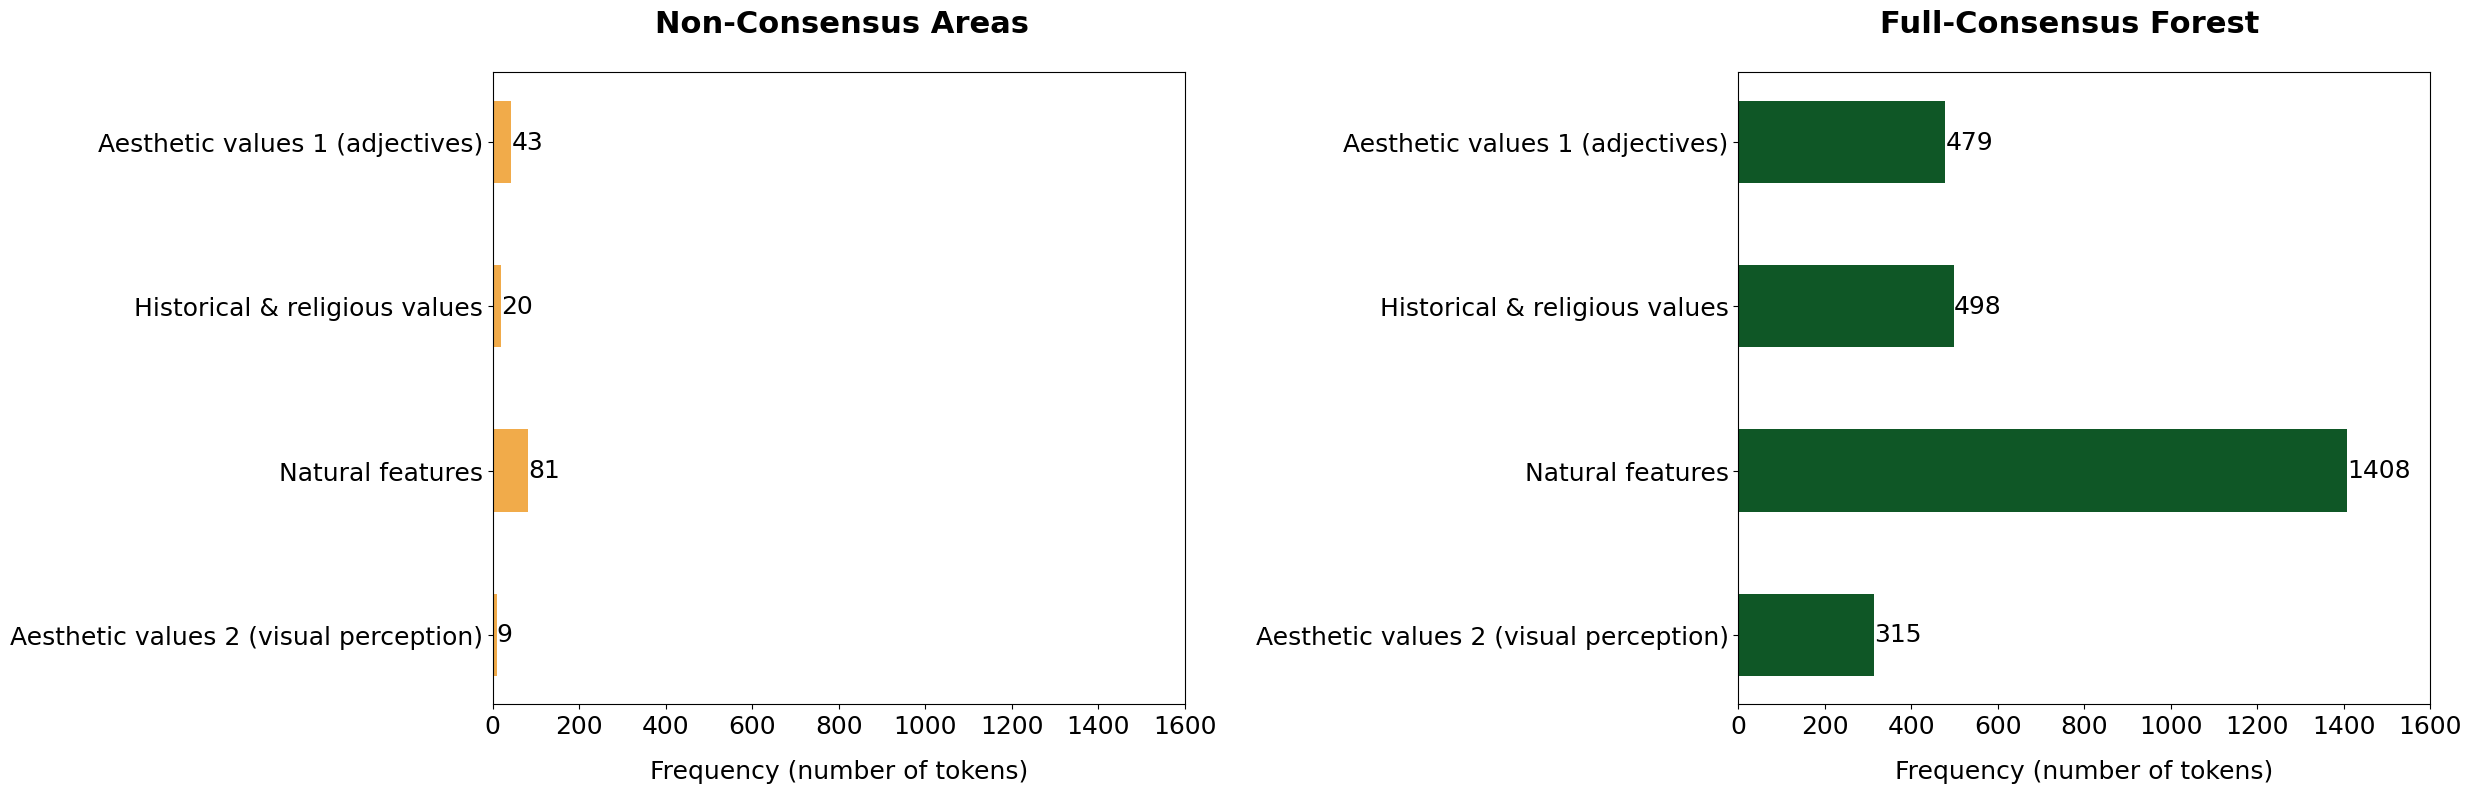

In [61]:
# STEP 3: CLUSTER COMPARISON
# Create horizontal bar charts for token counts per cluster for each class

# Set up fig and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))

# Set up horizontal bar charts
bar_chart_c3 = axes[0].barh(c3_token_counts_df["cluster_name"], 
                            c3_token_counts_df["token_count"],
                            color = "#F1AB4A",
                            height = 0.5)

bar_chart_c6 = axes[1].barh(c6_token_counts_df["cluster_name"], 
                            c6_token_counts_df["token_count"],
                            color = "#0F5726",
                            height = 0.5)

# Customise yaxis order, set up labels and extend xlim to fit value labels
axes[0].invert_yaxis()  
axes[0].set_xlabel('Frequency (number of tokens)', fontsize=18, labelpad=15)
axes[0].bar_label(bar_chart_c3, fontsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].tick_params(axis='x', labelsize=18)
axes[0].set_xlim(right=1600) 

axes[1].invert_yaxis() 
axes[1].set_xlabel('Frequency (number of tokens)', fontsize=18, labelpad=15)
axes[1].bar_label(bar_chart_c6, fontsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].tick_params(axis='x', labelsize=18)
axes[1].set_xlim(right=1600) 

# Add column titles (first two numbers control the position)
fig.text(0.19, 0.95, "Non-Consensus Areas", fontsize=22, fontweight='bold')
fig.text(0.68, 0.95, "Full-Consensus Forest", fontsize=22, fontweight='bold')

# Adjust white space at the top to fit in main titles and adjust space between rows/columns
plt.subplots_adjust(top=0.90, hspace=0.3, wspace=0.8)

# Save the combined figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_cluster_counts_per_class.png', bbox_inches='tight')

# Show plot
plt.show()


In [65]:
# STEP 3: CLUSTER MEMBERSHIP - TOKEN COMPARISON

# Create function for getting the frequenies for each token (using another function from above)
def cluster_token_freqs(df, clus_range):
    clus_freqs = []
    for clus_num in clus_range:
        clus_freq = get_cluster_freq(df, clus_num)
        clus_freqs.append(clus_freq)
    return clus_freqs

# Run the cluster_token_freqs function for each cluster for class 3 and 6
c3_clus3, c3_clus4, c3_clus8, c3_clus11 = cluster_token_freqs(filtered_clusters_c3, [3, 4, 8, 11])
c6_clus3, c6_clus4, c6_clus8, c6_clus11 = cluster_token_freqs(filtered_clusters_c6, [3, 4, 8, 11])

# Create function for generating dfs with top 10 tokens from each cluster 
def top10_tokens(counter_obj):
    top10_df = pd.DataFrame.from_records(counter_obj.most_common(10), columns=['token','count'])
    return top10_df

# Use function for creating dfs per class and cluster
c3_clus3_top10_df = top10_tokens(c3_clus3)
c3_clus4_top10_df = top10_tokens(c3_clus4)
c3_clus8_top10_df = top10_tokens(c3_clus8)
c3_clus11_top10_df = top10_tokens(c3_clus11)

c6_clus3_top10_df = top10_tokens(c3_clus3)
c6_clus4_top10_df = top10_tokens(c6_clus4)
c6_clus8_top10_df = top10_tokens(c6_clus8)
c6_clus11_top10_df = top10_tokens(c6_clus11)

# Check
#c3_clus5_top10_df


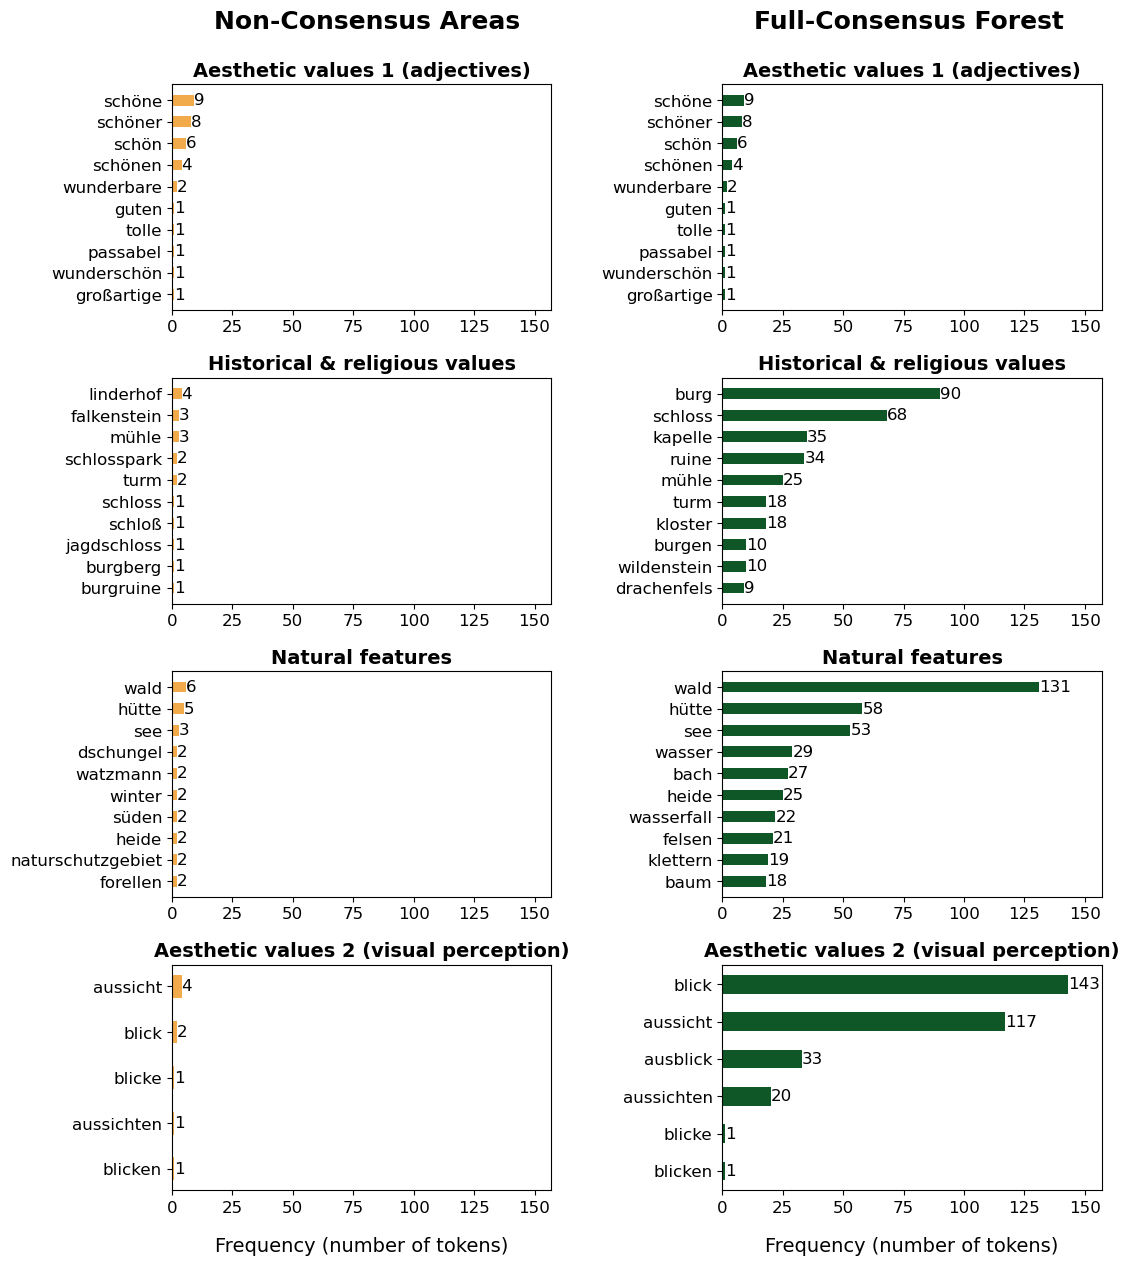

In [106]:
# STEP 3: CLUSTER MEMBERSHIP - TOKEN COMPARISON
# Create horizontal bar charts for individual token counts per cluster for each class

# Create a list of the dfs to plot (one per class)
c3_token_count_list = [c3_clus3_top10_df, c3_clus4_top10_df, c3_clus8_top10_df, c3_clus11_top10_df]
c6_token_count_list = [c6_clus3_top10_df, c6_clus4_top10_df, c6_clus8_top10_df, c6_clus11_top10_df]


# Set up figs and axes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))

# Iterate through each word cloud to plot (class 3 in 1st column, class 6 in 2nd column) 
# note that all_titles is defined in word cloud code
for i in range(4):
    # Class 3 plots
    bar_chart_c3 = axes[i, 0].barh(c3_token_count_list[i]["token"], 
                                   c3_token_count_list[i]["count"],
                                   color = "#F1AB4A",
                                   height = 0.5)
    axes[i, 0].invert_yaxis()
    axes[i, 0].set_title(all_titles[i], fontsize=14, fontweight="bold")
    axes[i, 0].set_xlim(right=157)
    axes[i, 0].bar_label(bar_chart_c3, fontsize=12)
    axes[i, 0].tick_params(axis='y', labelsize=12)
    axes[i, 0].tick_params(axis='x', labelsize=12)
    axes[3, 0].set_xlabel('Frequency (number of tokens)', fontsize=14, labelpad=15)

    # Class 6 plots
    bar_chart_c6 = axes[i, 1].barh(c6_token_count_list[i]["token"], 
                                   c6_token_count_list[i]["count"],
                                   color = "#0F5726",
                                   height = 0.5)
    axes[i, 1].invert_yaxis()
    axes[i, 1].set_title(all_titles[i], fontsize=14, fontweight="bold")
    axes[i, 1].set_xlim(right=157)
    axes[i, 1].bar_label(bar_chart_c6, fontsize=12)
    axes[i, 1].tick_params(axis='y', labelsize=12)
    axes[i, 1].tick_params(axis='x', labelsize=12)
    axes[3, 1].set_xlabel('Frequency (number of tokens)', fontsize=14, labelpad=15)

# Adjust white space at the top to fit in main titles and adjust space between rows/columns
plt.subplots_adjust(top=0.90, hspace=0.2, wspace=0.3)

# Add column titles (first two numbers control the position)
fig.text(0.16, 0.94, "Non-Consensus Areas", fontsize=18, fontweight='bold')
fig.text(0.61, 0.94, "Full-Consensus Forest", fontsize=18, fontweight='bold')

# Adjust white space at the top to fit in main titles and adjust space between rows/columns
plt.subplots_adjust(top=0.90, hspace=0.3, wspace=0.45)

# Save the combined figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_token_counts_per_cluster_class.png', bbox_inches='tight')

# Show plot
plt.show()
